In [7]:
import dicom
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import tensorflow as tf

data_dir = 'I:/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('I:/stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [2]:
for patient in patients[:5]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))

(512, 512) 195
(512, 512) 265
(512, 512) 233
(512, 512) 173
(512, 512) 146


In [3]:
IMG_SIZE_PX = 50
SLICE_COUNT = 20

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


In [4]:
len(patients)

1595

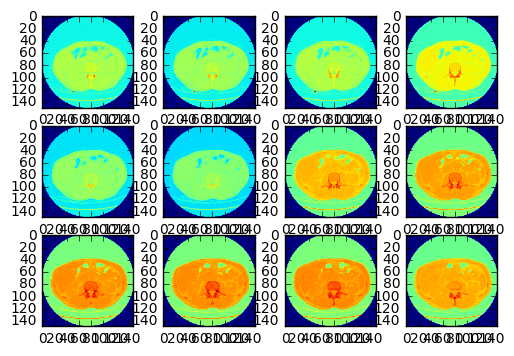

In [5]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(150,150))
        y.imshow(new_img)
    plt.show()

In [6]:
def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

much_data = []
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels_df,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

0
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
100
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
200
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
300
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
400
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data!
This is unlabeled data

In [8]:
IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [9]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [10]:
def convolutional_neural_network(x):
   
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)
    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [ ]:
much_data = np.load('muchdata-50-50-20.npy')
train_data = much_data[:-100]
validation_data = much_data[-100:]
with tf.device('/cpu:0'):

    def train_neural_network(x):
        prediction = convolutional_neural_network(x)
        cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

        hm_epochs = 10
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            successful_runs = 0
            total_runs = 0

            for epoch in range(hm_epochs):
                epoch_loss = 0
                for data in train_data:
                    total_runs += 1
                    try:
                        X = data[0]
                        Y = data[1]
                        _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                        epoch_loss += c
                        successful_runs += 1
                    except Exception as e:
                        pass

                print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

                correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
                accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

                print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))

            print('Done. Finishing accuracy:')
            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))

            print('fitment percent:',successful_runs/total_runs)

    train_neural_network(x)